In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.layouts import widgetbox
from bokeh.models.widgets import DataTable, NumberFormatter, TableColumn
output_notebook()

from k_fold import cross_validation
from proj1_helpers import *
from implementations import *
from helpers import *

Loading BokehJS ...

# Data exploration

In [2]:
y, x, ids = load_csv_data('../data/train.csv')
labels = np.array(np.genfromtxt('../data/train.csv', delimiter=",", names=True).dtype.names[2:])

In [3]:
def summary_table(data):
    data = data.copy()
    data[data==-999] = np.nan
    data = {
        'Label':labels,
        'Min':np.nanmin(data,axis=0),
        'Q1':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Q3':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Max':np.nanmax(data,axis=0),
        'Median':np.nanmedian(data,axis=0),
        'Mean':np.nanmean(data,axis=0),
        'Std':np.nanstd(data,axis=0),
        'Missing': np.count_nonzero(np.isnan(data),axis=0)/data.shape[0]
    }
    numberFormatter =  NumberFormatter(format='0.000')
    source = ColumnDataSource(data)
    label_colum = TableColumn(field='Label', title='Label', width=150)
    columns = [label_colum] + [TableColumn(field=label, title=label, formatter=numberFormatter, width=80)\
               for label in [k for k in data.keys() if k != 'Label']]
    data_table = DataTable(source=source, columns=columns, width=900, height = 800)
    show(widgetbox(data_table, sizing_mode = 'scale_both'))
    
summary_table(x)

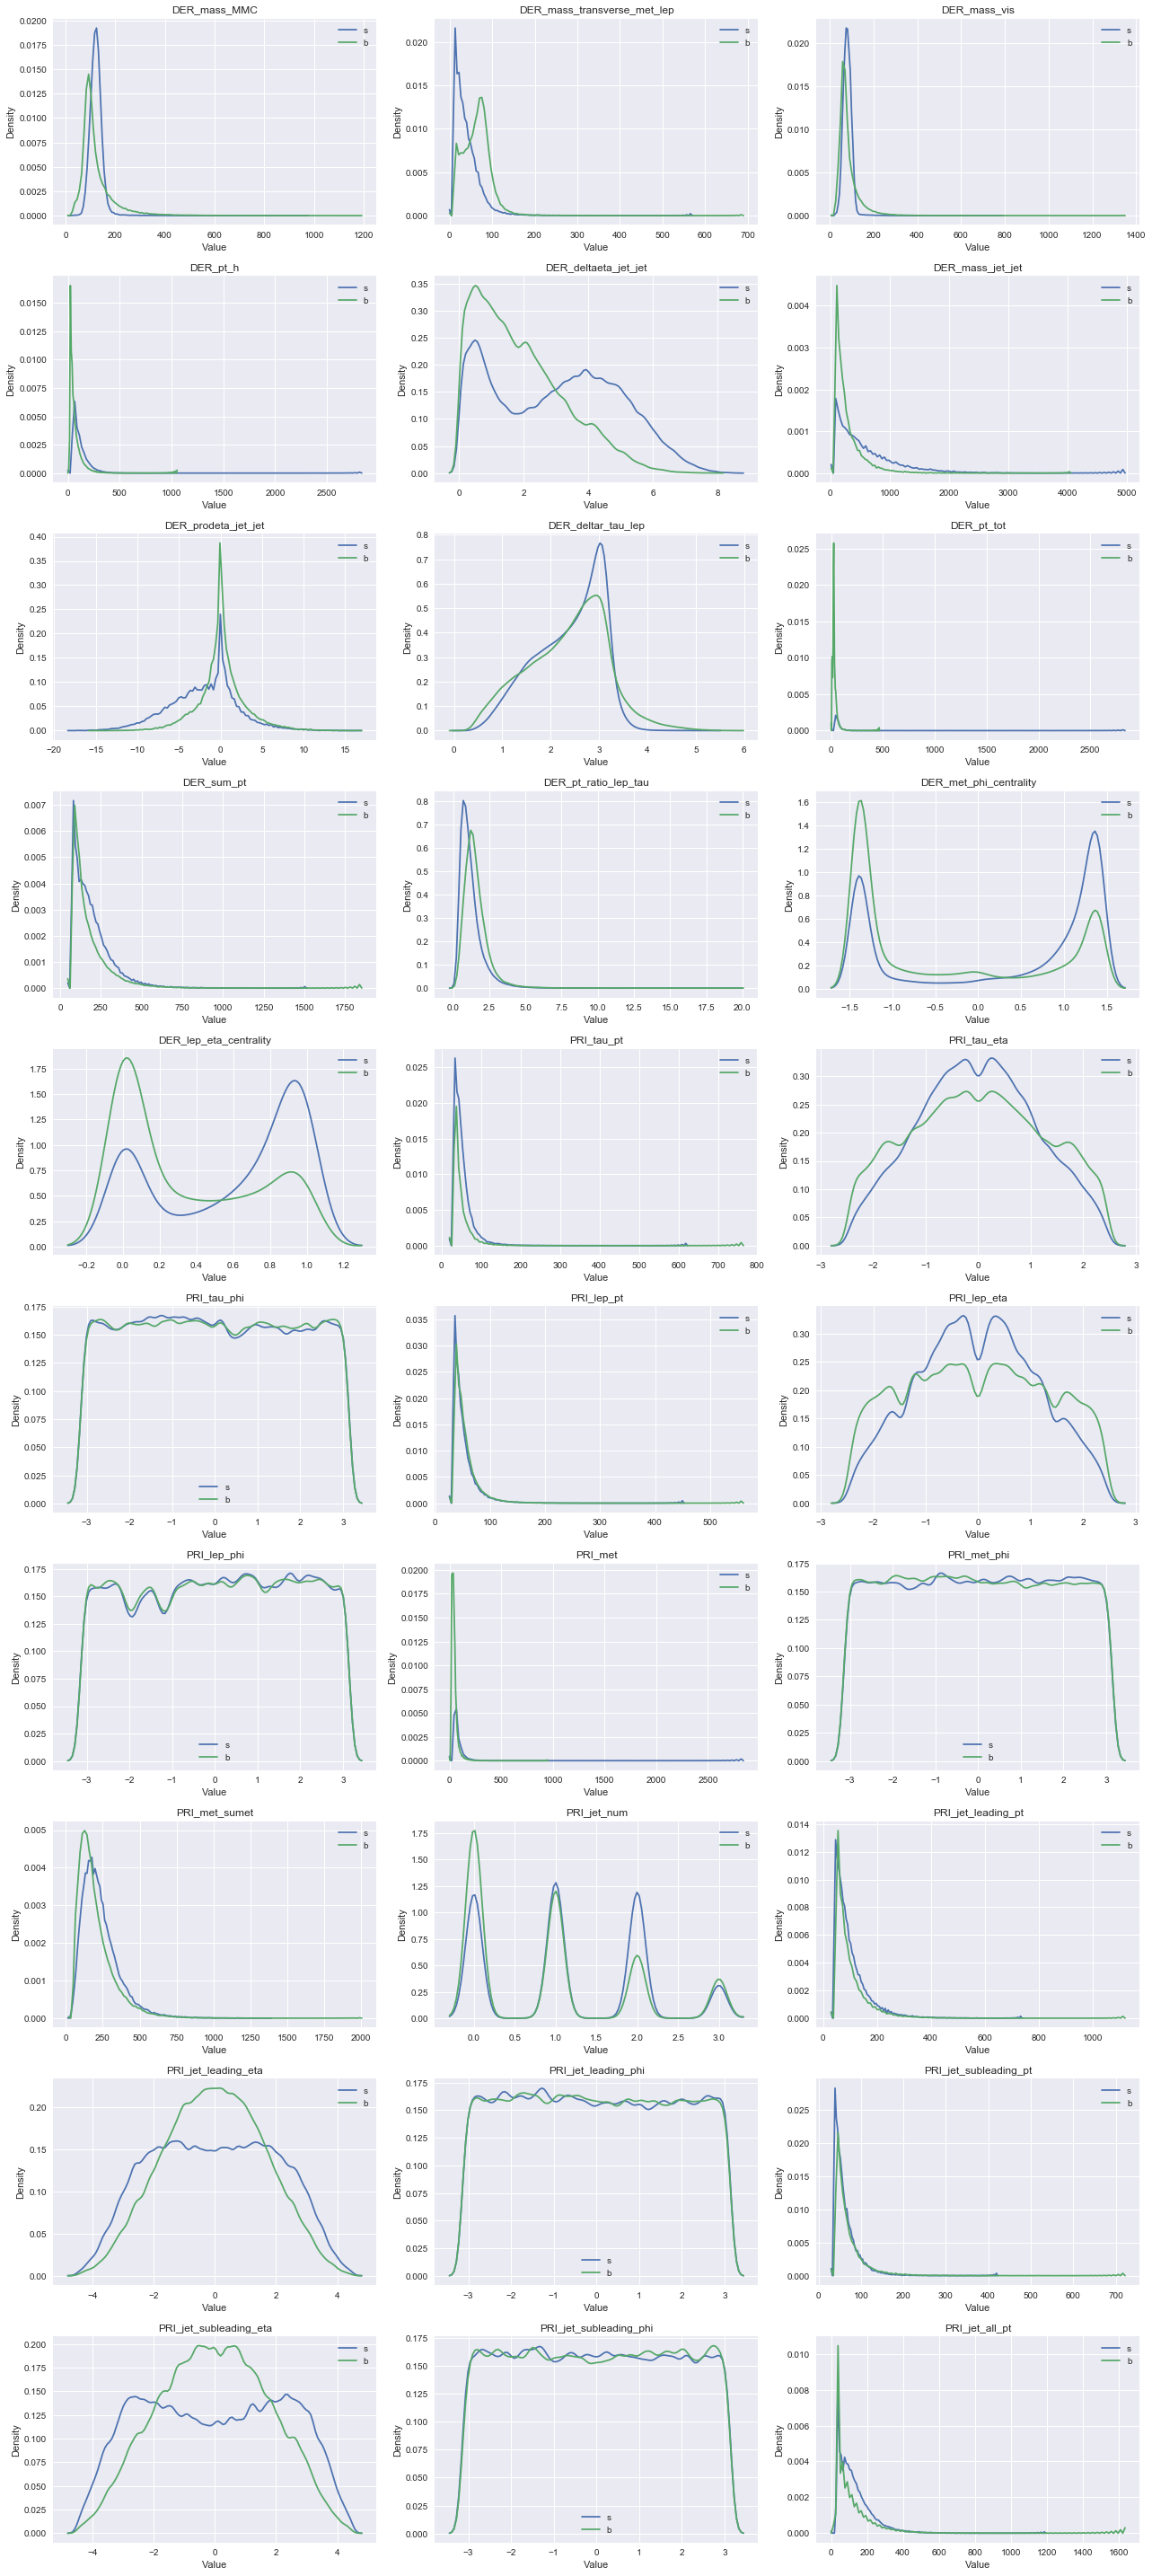

In [5]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [18,40]
for i, label in enumerate(labels):
    plt.subplot(10,3,i+1)
    values_s = x[y == 1]
    values_s = values_s[:,i]
    values_s[values_s==-999] = np.nan
#     plt.hist(values_s[~np.isnan(values_s)], label='s', histtype='step')
    sns.kdeplot(values_s[~np.isnan(values_s)], label='s', bw=0.1)
    
    values_b = x[y == -1]
    values_b = values_b[:,i]
    values_b[values_b==-999] = np.nan
#     plt.hist(values_b[~np.isnan(values_b)], label='b', histtype='step')
    sns.kdeplot(values_b[~np.isnan(values_b)], label='b',bw=0.1)
    plt.title(label)
    plt.ylabel('Density')
    plt.xlabel('Value')
plt.tight_layout()

# Model building

In [2]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

In [3]:
y, x, ids = load_csv_data('../data/train.csv', sub_sample=True)
x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
num_samples = len(y)
tx = np.c_[np.ones(num_samples), x]

In [4]:
y = (y-1)/2.0

In [5]:
lambdas = np.logspace(-7,-1,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 10, logistic_regression, compute_loss_logistic, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 100000, 'gamma': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:33: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(y.T @ np.log(sigma_xn_w) + (1-y).T @ np.log(1-sigma_xn_w))
/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(np.exp(-t)+1)
/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:33: RuntimeWarning: invalid value encountered in double_scalars
  loss = np.sum(y.T @ np.log(sigma_xn_w) + (1-y).T @ np.log(1-sigma_xn_w))


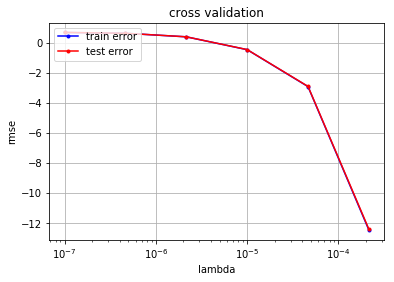

In [6]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [7]:
lambdas[np.argmin(rmse_te)]

0.0046415888336127729

In [67]:
tx

array([[ 1.        ,  0.48528033,  0.03965436, ...,  1.54863904,
         1.5407369 ,  0.39818214],
       [ 1.        ,  0.67601018,  0.63344061, ..., -0.64686729,
        -0.64686766, -0.23179611],
       [ 1.        ,  0.3724594 , -0.64151886, ..., -0.64686729,
        -0.64686766, -0.10829837],
       ..., 
       [ 1.        ,  0.49445625, -1.22366112, ..., -0.64686729,
        -0.64686766,  0.23416077],
       [ 1.        ,  0.34254595, -0.11217409, ..., -0.64686729,
        -0.64686766, -0.41106251],
       [ 1.        ,  0.46533331, -1.31829705, ..., -0.64686729,
        -0.64686766, -0.22539659]])

In [112]:
lambdas = np.logspace(-7,-1,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 10, reg_logistic_regression, compute_loss_logistic_reg, {'lambda_': lambda_,'initial_w': np.zeros(tx.shape[1]), 'max_iters': 100000, 'gamma': 0.001}, {'lambda_': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

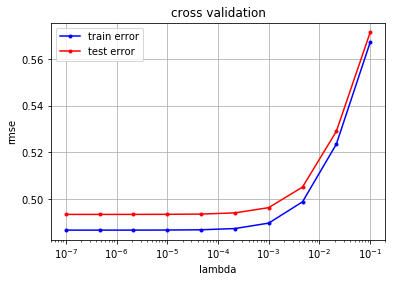

In [113]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [111]:
lambdas[np.argmin(rmse_te)]

0.001